# black-box regression results

Generates figures comparing performance on the black-box regression problems.

In [13]:
import pandas as pd
import json
import numpy as np
from glob import glob
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('pdf', fonttype=42)
matplotlib.rc('ps', fonttype=42)

import os
sns.set(font_scale=1.25, style='whitegrid')
sns.set(palette='magma')

# rdir = '../results/'
rdir = '../results_blackbox/'
# figdir = 'figs/black-box' 
figdir = '../paper/'
# Set to path to PMLB datasets
datadir = '../datasets/pmlb/datasets/'
print('figdir:',figdir)
def save(name='tmp',h=None):
    name = name.strip().replace(' ','-').replace('%','pct')
    if h == None:
        h = plt.gcf()
    h.tight_layout()
    print('saving',figdir+'/'+name+'.pdf')
    if not os.path.exists(figdir):
        os.makedirs(figdir)
    plt.savefig(figdir+'/'+name+'.pdf', bbox_inches='tight')
    
symbolic_algs = [
    'AFP', 
    'AFP_FE',
    'BSR',
    'DSR',
    'FFX',

    # brush with mabs
    'Baseline',
    "C-D-UCB1",
    "C-D-TS",
    "D-UCB1",
    "D-TS",

    'FEAT S-Split',
    'FEAT SD-Split',
    'FEAT D-Split',
    'FEAT',

    'EPLEX',
    'GP-GOMEA',
    'gplearn',
    'ITEA', 
    'MRGP', 
    'Operon',
    'SBP-GP',
    'AIFeynman'
]
nongp_algs = [
    'BSR',
    'DSR',
    'AIFeynman'
]
gp_algs = [
    'AFP', 
    'AFP_FE',
    'FFX',

    'FEAT S-Split',
    'FEAT SD-Split',
    'FEAT D-Split',
    'FEAT',

    # brush with mabs
    'Baseline',
    "C-D-UCB1",
    "C-D-TS",
    "D-UCB1",
    "D-TS",

    'EPLEX',
    'GP-GOMEA',
    'gplearn',
    'ITEA', 
    'MRGP', 
    'Operon',
    'SBP-GP',
]

figdir: ../paper/


# read data from feather

In [14]:
##########
# load data from json
##########
frames = []
comparison_cols = [
    'dataset',
    'algorithm',
    'random_state',
    'time_time',
    'model_size',
    'symbolic_model',
    'r2_test',
    'mse_test',
    'mae_test',
    'params'
]
fails = []
import pdb
for f in tqdm(glob(rdir + '/*/*.json')):
    if 'cv_results' in f: 
        continue
    # leave out symbolic data
    if 'feynman_' in f or 'strogatz_' in f:
        continue
    # leave out LinearReg, Lasso (we have SGD with penalty)
    if any([m in f for m in ['LinearRegression','Lasso','EHCRegressor']]):
        continue
    try: 
        r = json.load(open(f,'r'))
        if isinstance(r['symbolic_model'],list):
#             print(f)
            sm = ['B'+str(i)+'*'+ri for i, ri in enumerate(r['symbolic_model'])]
            sm = '+'.join(sm)
            r['symbolic_model'] = sm
            
        sub_r = {k:v for k,v in r.items() if k in comparison_cols}
    #     df = pd.DataFrame(sub_r)
        frames.append(sub_r) 
    #     print(f)
    #     print(r.keys())
    except Exception as e:
        fails.append([f,e])
        pass
    
print(len(fails),'fails:',fails)
# df_results = pd.concat(frames)
df_results = pd.DataFrame.from_records(frames)
df_results['params_str'] = df_results['params'].apply(str)
df_results = df_results.drop(columns=['params'])
##########
# cleanup
##########
df_results = df_results.rename(columns={'time_time':'training time (s)'})
df_results.loc[:,'training time (hr)'] = df_results['training time (s)']/3600

# rename FeatStaticSplit to StaticSplit
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('featStaticSplit','FEAT S-Split'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('featSemiSplit','FEAT SD-Split'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('featDynamicSplit','FEAT D-Split'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('feat','FEAT(e-lex)'))

df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('brush_C_D_UCB1','C-D-UCB1'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('brush_C_D_TS','C-D-TS'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('brush_D_UCB1','D-UCB1'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('brush_D_TS','D-TS'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('brush','Baseline'))

# add modified R2 with 0 floor
df_results['r2_zero_test'] = df_results['r2_test'].apply(lambda x: max(x,0))

# label friedman ddatasets
df_results.loc[:,'friedman_dataset'] = df_results['dataset'].str.contains('_fri_')

print('loaded',len(df_results),'results')
# additional metadata

df_results['symbolic_alg'] = df_results['algorithm'].apply(lambda x: x in symbolic_algs)

for col in ['algorithm','dataset']:
    print(df_results[col].nunique(), col+'s')

##########
# save results
##########
df_results.to_feather('../results/black-box_results_local.feather')
print('results saved to ../results/black-box_results_local.feather')

########
print('mean trial count:')
print(df_results.groupby('algorithm')['dataset'].count().sort_values()
      / df_results.dataset.nunique())

100%|██████████| 10567/10567 [00:31<00:00, 332.30it/s]


0 fails: []
loaded 10567 results
9 algorithms
122 datasets
results saved to ../results/black-box_results_local.feather
mean trial count:
algorithm
FEAT D-Split     9.180328
FEAT S-Split     9.196721
FEAT SD-Split    9.196721
FEAT(e-lex)      9.221311
Baseline         9.918033
C-D-UCB1         9.942623
D-UCB1           9.983607
C-D-TS           9.983607
D-TS             9.991803
Name: dataset, dtype: float64


In [15]:

##########
# load results
##########
df_results = pd.read_feather('../results/black-box_results.feather')

# # Brush results
# df_results_brush = pd.read_feather('../results/black-box_results_brush.feather')
# df_results = pd.concat([df_results_brush, df_results], axis=0)

# df_results_brush = pd.read_feather('../results/black-box_results_C_D_UCB1.feather')
# df_results = pd.concat([df_results_brush, df_results], axis=0)

# combine with local results ---------------------------------
df_results_local = pd.read_feather('../results/black-box_results_local.feather')
df_results = pd.concat([df_results_local, df_results], axis=0)

# removing feat (it was a sanity check)
# df_results = df_results.loc[df_results['algorithm']!='FEAT(e-lex)']

# Removing mislabeled datasets (these are clf, but PMLB v1.0 had it as regr)
df_results = df_results[ ~df_results["dataset"].isin(["banana", "titanic"]) ]

print('mean trial count:')
print(df_results.groupby('algorithm')['dataset'].count().sort_values()
      / df_results.dataset.nunique())

mean trial count:
algorithm
AIFeynman        7.688525
FEAT D-Split     9.180328
FEAT S-Split     9.196721
FEAT SD-Split    9.196721
FEAT(e-lex)      9.221311
MRGP             9.745902
FEAT             9.827869
AFP              9.836066
DSR              9.836066
EPLEX            9.836066
BSR              9.836066
KernelRidge      9.836066
FFX              9.836066
GP-GOMEA         9.836066
AFP_FE           9.836066
AdaBoost         9.836066
MLP              9.836066
Operon           9.836066
RandomForest     9.836066
SBP-GP           9.836066
XGB              9.836066
LGBM             9.836066
Linear           9.836066
ITEA             9.836066
gplearn          9.836066
Baseline         9.918033
C-D-UCB1         9.942623
C-D-TS           9.983607
D-UCB1           9.983607
D-TS             9.991803
Name: dataset, dtype: float64


In [16]:
df_results['dataset'].nunique()

122

In [17]:
df_results['algorithm'].value_counts()

D-TS             1219
D-UCB1           1218
C-D-TS           1218
C-D-UCB1         1213
Baseline         1210
AdaBoost         1200
DSR              1200
BSR              1200
AFP              1200
ITEA             1200
GP-GOMEA         1200
FFX              1200
AFP_FE           1200
EPLEX            1200
Linear           1200
MLP              1200
Operon           1200
RandomForest     1200
XGB              1200
gplearn          1200
KernelRidge      1200
LGBM             1200
SBP-GP           1200
FEAT             1199
MRGP             1189
FEAT(e-lex)      1125
FEAT S-Split     1122
FEAT SD-Split    1122
FEAT D-Split     1120
AIFeynman         938
Name: algorithm, dtype: int64

In [18]:
# ignoring new datasets from PMLB that hasnt been benchmarked with other methods yet
# df_results[['algorithm', 'dataset']].value_counts().unstack().sum(axis=0).sort_values()

print(df_results.shape)
df_results = df_results[ ~df_results["dataset"].isin([
                                                        "nikuradse_2",
                                                        "nikuradse_1"
]) ]

print(df_results.shape)


(35493, 14)
(35315, 14)


In [19]:
# removing specific models (for results reporting --- there is several papers using these results)

print(df_results.shape)
df_results = df_results[ ~df_results["algorithm"].isin([
    # "D-TS",
    # "D-UCB1",
    # "C-D-TS",
    # "C-D-UCB1",
    # "Baseline",
    "FEAT(e-lex)",
    'FEAT SD-Split',
    'FEAT S-Split',
    'FEAT D-Split',
]) ]

print(df_results.shape)

(35315, 14)
(30904, 14)


## summarize results by dataset, including ranking

In [20]:
df_results2 = df_results.merge(df_results.groupby('dataset')['algorithm'].nunique().reset_index(),
                              on='dataset',suffixes=('','_count'))

                                       
# rankings per trial per dataset
for col in [c for c in df_results2.columns if c.endswith('test') or c.endswith('size')]:
    ascending = 'r2' not in col
    df_results2[col+'_rank_per_trial']=df_results2.groupby(['dataset','random_state'])[col].apply(lambda x: 
                                                                              round(x,3).rank(
                                                                              ascending=ascending))
    
df_sum = df_results2.groupby(['algorithm','dataset'],as_index=False).median()
df_sum['rmse_test'] = df_sum['mse_test'].apply(np.sqrt)
df_sum['log_mse_test'] = df_sum['mse_test'].apply(lambda x: np.log(1+x))
df_results = df_results2

# rankings and normalized scores per dataset
for col in [c for c in df_sum.columns if c.endswith('test') or c.endswith('size')]:
    ascending = 'r2' not in col
    df_sum[col+'_rank']=df_sum.groupby(['dataset'])[col].apply(lambda x: 
                                                                        round(x,3).rank(ascending=ascending)
                                                                  )
    df_sum[col+'_norm'] = df_sum.groupby('dataset')[col].apply(lambda x: (x-x.min())/(x.max()-x.min()))
    
###################
# save summary data
###################
df_sum.to_csv('../results/results_black-box_summary.csv.gz',compression='gzip',index=False)

df_sum

/tmp/ipykernel_104379/776791570.py:8: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_results2[col+'_rank_per_trial']=df_results2.groupby(['dataset','random_state'])[col].apply(lambda x:
/tmp/ipykernel_104379/776791570.py:8: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_results2[col+'_rank_p

,algorithm,dataset,random_state,training time (s),mse_test,mae_test,r2_test,model_size,training time (hr),r2_zero_test,...,r2_test_rank,r2_test_norm,model_size_rank,model_size_norm,r2_zero_test_rank,r2_zero_test_norm,rmse_test_rank,rmse_test_norm,log_mse_test_rank,log_mse_test_norm
0,AFP,1027_ESL,13879.5,1210.966865,0.365049,0.442612,0.830930,20.5,0.336380,0.830930,...,18.0,0.922184,10.0,0.000770,18.0,0.922184,19.0,0.139514,19.0,0.123830
1,AFP,1028_SWD,13879.5,3017.658321,0.438023,0.538419,0.314517,47.0,0.838238,0.314517,...,19.0,0.835045,14.0,0.000378,19.0,0.808090,21.0,0.216281,21.0,0.208446
2,AFP,1029_LEV,13879.5,2622.206193,0.433124,0.508817,0.521904,23.5,0.728391,0.521904,...,18.0,0.939429,10.5,0.000229,18.0,0.934869,18.0,0.075124,18.0,0.070675
3,AFP,1030_ERA,13879.5,3007.024177,2.496171,1.299746,0.358716,36.5,0.835284,0.358716,...,18.0,0.919178,15.0,0.003315,18.0,0.917586,16.0,0.066810,16.0,0.070855
4,AFP,1089_USCrime,13879.5,590.939726,549.423049,18.823004,0.639671,25.0,0.164150,0.639671,...,21.0,0.822717,12.0,0.001007,21.0,0.780937,20.0,0.200320,20.0,0.286474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3100,gplearn,687_sleuth_ex1605,13879.5,26662.282274,107.479353,8.918893,0.373679,14.5,7.406190,0.373679,...,10.0,0.997806,8.0,0.000238,10.0,0.779652,4.0,0.005244,4.0,0.018221
3101,gplearn,690_visualizing_galaxy,13879.5,21162.593308,399.074818,15.693803,0.953191,16.0,5.878498,0.953191,...,18.5,0.923560,4.0,0.000040,18.5,0.923560,19.0,0.140843,19.0,0.230959
3102,gplearn,695_chatfield_4,13879.5,28398.484904,311.234213,11.696317,0.843542,1.0,7.888468,0.843542,...,5.0,0.997885,1.0,0.000000,5.0,0.974512,10.0,0.010673,10.0,0.038788
3103,gplearn,706_sleuth_case1202,13879.5,22506.032915,3185.450642,40.642813,0.661283,11.5,6.251676,0.661283,...,2.0,0.999864,8.0,0.001220,2.0,0.994737,3.0,0.009024,3.0,0.029265


# plot comparisons

In [21]:

def compare(df_compare, x='r2_test',y='algorithm', row=None, col=None, scale=None, xlim=[],**kwargs):
    plt.figure()
    order = df_compare.groupby(y)[x].median().sort_values(ascending=False).index
    if scale=='log' and len(xlim)>0 and xlim[0] == 0:
        df_compare.loc[:,x] += 1
        xlim[0] = 1
        xnew = '1 + '+x
        df_compare=df_compare.rename(columns={x:xnew})
        x = xnew
    
    sns.catplot(data=df_compare, 
                kind='point',
#                 color='w',
                y=y,
                x=x,
                order=order,
                fliersize=0,
#                 notch=True,
                row=row,
                col=col,
                palette='flare_r',
                **kwargs
               )
    plt.ylabel('')
    if len(xlim)>0:
        plt.xlim(xlim[0],xlim[1])
    if scale:
        plt.gca().set_xscale(scale)
    
    save(name='_'.join(['cat-boxplot',x + '-by-'+ y]) )
    if col:
        save(name='_'.join(['cat-boxplot',x + '-by-'+ y] + [col]) )

## point plot comparisons on PMLB

Index(['*Operon', '*SBP-GP', '*FEAT', '*C-D-UCB1', '*EPLEX', '*D-UCB1', 'XGB',
       '*C-D-TS', 'LGBM', '*GP-GOMEA', 'AdaBoost', 'RandomForest', '*D-TS',
       '*ITEA', '*Baseline', '*AFP_FE', '*AFP', '*FFX', 'KernelRidge',
       '*gplearn', '*DSR', '*MRGP', 'MLP', 'Linear', '*BSR', '*AIFeynman'],
      dtype='object', name='*algorithm*')


,r2_test,rmse_test,model_size,training time (s)
0,0.830930,0.604193,20.5,1210.966865
1,0.314517,0.661833,47.0,3017.658321
2,0.521904,0.658121,23.5,2622.206193
3,0.358716,1.579928,36.5,3007.024177
4,0.639671,23.439775,25.0,590.939726
...,...,...,...,...
3100,0.373679,10.367225,14.5,26662.282274
3101,0.953191,19.976857,16.0,21162.593308
3102,0.843542,17.641831,1.0,28398.484904
3103,0.661283,56.439797,11.5,22506.032915


/home/ch246537/.conda/envs/srbench-brush/lib/python3.9/site-packages/seaborn/axisgrid.py:1609: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  func(x=x, y=y, **kwargs)
/home/ch246537/.conda/envs/srbench-brush/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ch246537/.conda/envs/srbench-brush/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ch246537/.conda/envs/srbench-brush/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ch246537/.conda/envs/srbench-brush/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ch246537/

saving ../paper//pairgrid-pointplot_r2_test_rmse_test_model_size_training-time-(s).pdf


<Figure size 640x480 with 0 Axes>

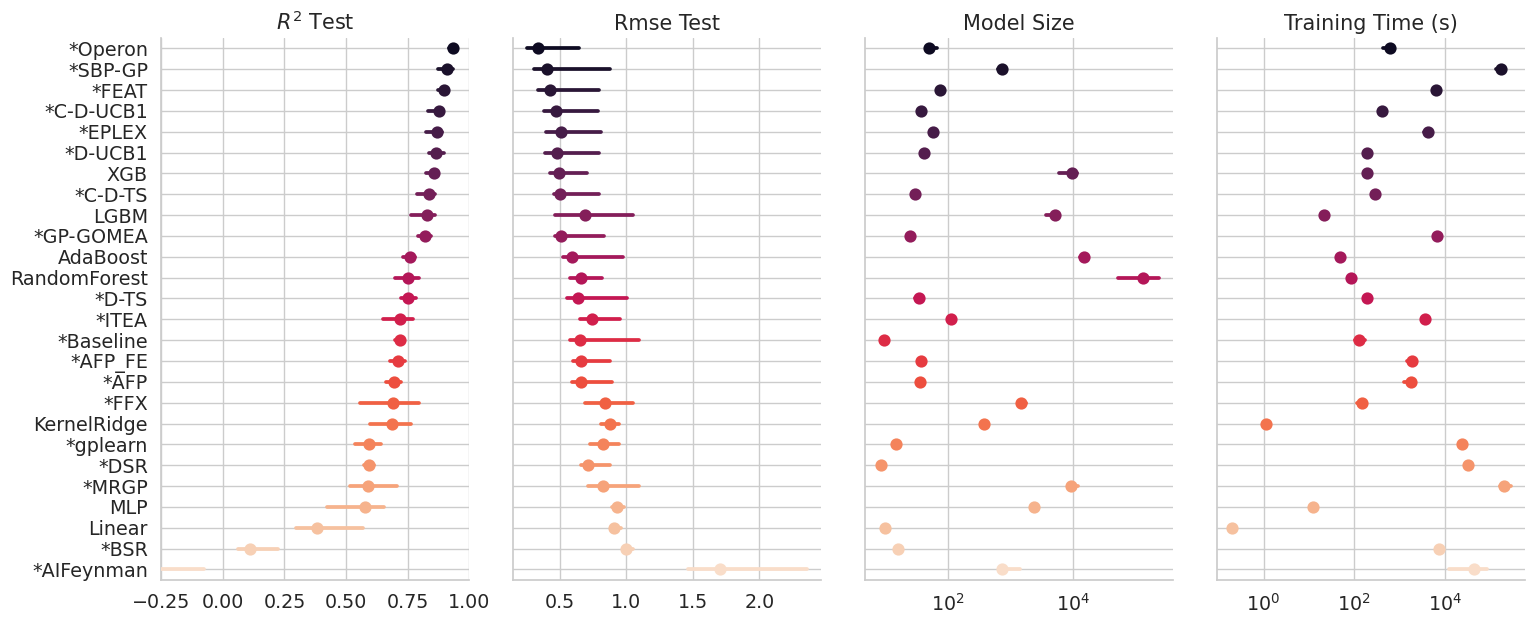

In [22]:
# Make the PairGrid
sns.set(font_scale=1.25, style='whitegrid')
# sns.set(palette='magma')
sns.despine(left=True, bottom=True)

df_plot=df_sum.copy()

df_plot['*algorithm*'] = df_plot['algorithm'].apply(lambda x: '*'+x if x in symbolic_algs else x)

# different options
x_vars=[
#         'r2_test_norm',
        'r2_test',
#         'r2_test_rank',
        'rmse_test',
#         'log_mse_test',
        'model_size',
#         'model_size_rank',
       'training time (s)',
]
order = df_plot.groupby('*algorithm*')[x_vars[0]].median().sort_values(
                    ascending='r2' not in x_vars[0] or 'rank' in x_vars[0]).index

print(order)

display(df_plot[x_vars])
g = sns.PairGrid(df_plot, 
                 x_vars=x_vars,
                 y_vars=['*algorithm*'],
                 height=6.5, 
                 aspect=0.6,
                  hue="*algorithm*",
                  hue_order=order,
                  palette=sns.color_palette("rocket", n_colors=26),
#                  hue='symbolic_dataset'
                )

# Draw a dot plot 
g.map(sns.pointplot, 
      #size=10,
      orient="h",
      #jitter=False,
      order=order,
      hue_order=order,
      palette=sns.color_palette("rocket", n_colors=26),
      #linewidth=1,
      #markeredgecolor='w',
      join=False,
      estimator=np.median,
      n_boot=1000,
      ci=95
     )
# # Use semantically meaningful titles for the columns
titles = [x.replace('_',' ').title().replace('(S)','(s)').replace('R2','$R^2$') for x in x_vars]
g.axes.flat[0].set_ylabel('')
for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)
    ax.set_xlabel('')
    
    if any([n in title.lower() for n in ['size','time']]):
        ax.set_xscale('log')
    
    if title == '$R^2$ Test':
        ax.set_xlim([-.25,1])

    # Make the grid horizontal instead of vertical
    ax.yaxis.grid(True)


save(name='_'.join(['pairgrid-pointplot']+x_vars))

## effect of friedman datasets

/home/ch246537/.conda/envs/srbench-brush/lib/python3.9/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.87199254, 0.3633634, 0.35974223)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


saving ../paper//friedman_comparison_pairgrid-pointplot_normalized_R2_test.pdf


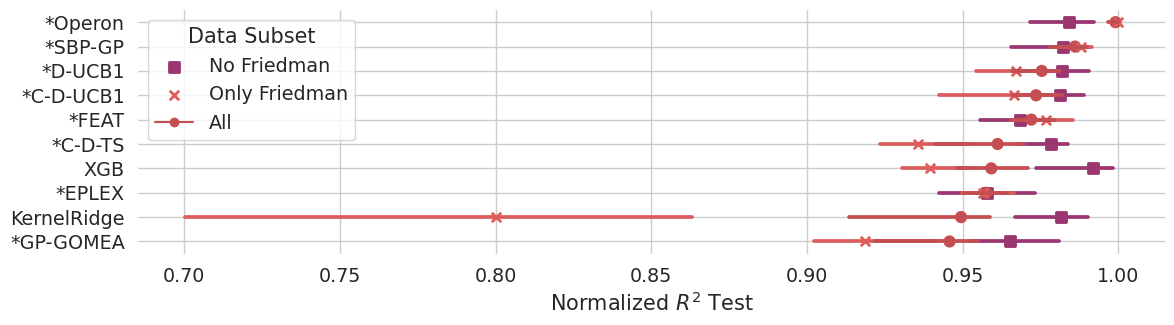

In [23]:
# Make the PairGrid
sns.set_style("whitegrid")
df_plot=df_sum.copy()
df_plot['*algorithm*'] = df_plot['algorithm'].apply(lambda x: '*'+x if x in symbolic_algs else x)
df_plot = df_plot[['*algorithm*','r2_test','r2_test_norm','r2_test_rank','friedman_dataset']]

x='r2_test'
markers = ['o','s','x']
colors = sns.color_palette('flare',n_colors=3)
for x in ['r2_test_norm']:
    h = plt.figure(figsize=(12,3.5))
    ax = plt.gca()
    order = df_plot.groupby('*algorithm*')[x].median().sort_values(
                    ascending='r2' not in x or 'rank' in x).index[:10]
    i = 0
    axes = []
    g = sns.pointplot(ax=ax,
                  data=df_plot,
                  x=x,
                  y='*algorithm*',
                  hue='friedman_dataset',
                  #size=10,
                  orient="h",
                  order=order,
                  markers=['s','x'],
                  palette="flare_r",
                  join=False,
                  estimator=np.median,
                  #legend_out=True
                 )
    # all PMLB
    g2 = sns.pointplot(ax=ax,
                  data=df_plot,
                  x=x,
                  y='*algorithm*',
#                   hue='friedman_dataset',
                  #size=10,
                  orient="h",
                  order=order,
                  color='r',
#                   palette="flare_r",
                  join=False,
                  estimator=np.median,
                  markers = ['o'],
                  #legend_out=True
                 )
    # add all PMLB to legend
    handles, labels = ax.get_legend_handles_labels()
    #Create custom artists
    both = plt.Line2D((0,1),(0,0), color='r', marker='o', linestyle='-', label='All')
    handles.append(both)
    plt.legend(title='Data Subset',
               handles=handles, 
               labels=['No Friedman','Only Friedman','All'])
    
    if x=='r2_test':
        plt.xlim([-.5,1.0])
    if 'norm' in x:
        x='normalized_R2_test'
    sns.despine(left=True, bottom=True)
#         plt.title(prefix.replace('_',' ').title())
    axes.append(ax)
    i+=1
    plt.tight_layout()
    for ax in axes:
        ax.set_ylabel('')
        ax.set_xlabel(x.replace('_',' ').title().replace('(S)','(s)').replace('R2','$R^2$'))
        ax.yaxis.grid(True)
        ax.xaxis.grid(True)


    save(name='friedman_comparison_'+'_'.join(['pairgrid-pointplot']+[x]))

# training time versus dataset size

In [24]:
import pandas as pd
# for dataset, dfg in df_sum.groupby('dataset'):
def get_size(dataset,i):
    df = pd.read_csv(datadir+dataset+'/'+dataset+'.tsv.gz',sep='\t') 
    return df.shape[i]
df_sum.loc[:,'dataset_nsamples'] = df_sum['dataset'].apply(lambda x: get_size(x,0))
df_sum.loc[:,'dataset_nsamples_train'] = df_sum['dataset'].apply(lambda x: min(get_size(x,0),10000))
df_sum.loc[:,'dataset_nfeatures'] = df_sum['dataset'].apply(lambda x: get_size(x,1))
df_sum.loc[:,'dataset_npoints'] = df_sum['dataset_nsamples']*df_sum['dataset_nfeatures']
df_sum

,algorithm,dataset,random_state,training time (s),mse_test,mae_test,r2_test,model_size,training time (hr),r2_zero_test,...,r2_zero_test_rank,r2_zero_test_norm,rmse_test_rank,rmse_test_norm,log_mse_test_rank,log_mse_test_norm,dataset_nsamples,dataset_nsamples_train,dataset_nfeatures,dataset_npoints
0,AFP,1027_ESL,13879.5,1210.966865,0.365049,0.442612,0.830930,20.5,0.336380,0.830930,...,18.0,0.922184,19.0,0.139514,19.0,0.123830,488,488,5,2440
1,AFP,1028_SWD,13879.5,3017.658321,0.438023,0.538419,0.314517,47.0,0.838238,0.314517,...,19.0,0.808090,21.0,0.216281,21.0,0.208446,1000,1000,11,11000
2,AFP,1029_LEV,13879.5,2622.206193,0.433124,0.508817,0.521904,23.5,0.728391,0.521904,...,18.0,0.934869,18.0,0.075124,18.0,0.070675,1000,1000,5,5000
3,AFP,1030_ERA,13879.5,3007.024177,2.496171,1.299746,0.358716,36.5,0.835284,0.358716,...,18.0,0.917586,16.0,0.066810,16.0,0.070855,1000,1000,5,5000
4,AFP,1089_USCrime,13879.5,590.939726,549.423049,18.823004,0.639671,25.0,0.164150,0.639671,...,21.0,0.780937,20.0,0.200320,20.0,0.286474,47,47,14,658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3100,gplearn,687_sleuth_ex1605,13879.5,26662.282274,107.479353,8.918893,0.373679,14.5,7.406190,0.373679,...,10.0,0.779652,4.0,0.005244,4.0,0.018221,62,62,6,372
3101,gplearn,690_visualizing_galaxy,13879.5,21162.593308,399.074818,15.693803,0.953191,16.0,5.878498,0.953191,...,18.5,0.923560,19.0,0.140843,19.0,0.230959,323,323,5,1615
3102,gplearn,695_chatfield_4,13879.5,28398.484904,311.234213,11.696317,0.843542,1.0,7.888468,0.843542,...,5.0,0.974512,10.0,0.010673,10.0,0.038788,235,235,13,3055
3103,gplearn,706_sleuth_case1202,13879.5,22506.032915,3185.450642,40.642813,0.661283,11.5,6.251676,0.661283,...,2.0,0.994737,3.0,0.009024,3.0,0.029265,93,93,7,651


In [25]:
df_sum.algorithm.unique()

array(['AFP', 'AFP_FE', 'AIFeynman', 'AdaBoost', 'BSR', 'Baseline',
       'C-D-TS', 'C-D-UCB1', 'D-TS', 'D-UCB1', 'DSR', 'EPLEX', 'FEAT',
       'FFX', 'GP-GOMEA', 'ITEA', 'KernelRidge', 'LGBM', 'Linear', 'MLP',
       'MRGP', 'Operon', 'RandomForest', 'SBP-GP', 'XGB', 'gplearn'],
      dtype=object)

In [26]:
df_sum['Method Family'] = df_sum['algorithm'].apply(lambda x: 'Operon' if x=='Operon' else 'XGB' if x=='XGB' else 'Other Non-GP SR' if x in nongp_algs else 'Other GP SR' if x in gp_algs else 'Other ML')

order = [
    'FEAT SD-Split',
    # 'FEAT S-Split',
    'FEAT D-Split',
    'FEAT(e-lex)',

    # 'Baseline',
    # "C-D-UCB1",
    # "C-D-TS",
    # "D-UCB1",
    # "D-TS",
]

marker_choice = {
    "FEAT S-Split"  : '<',
    # "FEAT SD-Split"  : '*',
    "FEAT D-Split"  : 'o',
    "FEAT(e-lex)" : 's',

    # 'Baseline' : '*',
    # "C-D-UCB1" : '<',
    # "C-D-TS" : '>',
    # "D-UCB1" : 's',
    # "D-TS" : 'o',
}

for col in ['dataset_nsamples_train','dataset_nsamples','dataset_nfeatures','dataset_npoints']:
    sns.set(palette='tab20')
    sns.set_style('whitegrid')
    sns.set_context("paper", font_scale=1.75, rc={"lines.linewidth": 1.5})

    plt.figure(figsize=(6,6))
    ax = sns.lineplot(
        data=df_sum.loc[df_sum.algorithm.isin([
            #'Operon',
            # 'FEAT SD-Split',
            'FEAT S-Split',
            'FEAT D-Split',
            'FEAT(e-lex)',
            #'EPLEX',
            #'SBP-GP',
            #'XGB',
            #'DSR',

            'Baseline',
            "C-D-UCB1",
            "C-D-TS",
            "D-UCB1",
            "D-TS",
            ])],
        x = col,
        y = 'training time (hr)',
#         hue='Method Family',
#         style='Method Family',
        hue='algorithm',
        hue_order=order,
        style='algorithm',
        markers=marker_choice,
        markersize=8,
        markerfacecolor=None,
        err_style='bars',
        alpha=0.85
#         facecolors=None
#         scatter_kws = {'facecolors':'none'}
    )
    ax.set_yscale('log')
    ax.set_xscale('log')
#     plt.legend(loc=[1.01,0])
    plt.xlabel(col.replace('_',' ').title())
    plt.ylabel('Training Time (hr)')
    save('training_time_'+col)

ValueError: These `markers` levels are missing values: {'D-TS', 'Baseline', 'C-D-UCB1', 'C-D-TS', 'D-UCB1'}

<Figure size 600x600 with 0 Axes>

<!-- # scores on symbolic datasets (prelim) -->

# Pareto plot

Plot the method results as trade-offs between accuracy and simplicity

In [ ]:
np.random.seed(42)
def bootstrap(val, n = 1000, fn=np.mean):
    val_samples = []
    for i in range(n):
        sample = np.random.randint(0,len(val)-1, size=len(val))
        val_samples.append( fn(val[sample]) )
    m = np.mean(val_samples)
    sd = np.std(val_samples)
    ci_upper  = np.quantile(val_samples,0.95)
    ci_lower  = np.quantile(val_samples,0.05)
    return m, sd, ci_upper,ci_lower

In [ ]:
import pdb
from pareto_utils import front
sns.set(font_scale=1, style='whitegrid')
labelsize=18
plt.figure(figsize=(7,7))
data = df_sum.copy() #.loc[df_sum.algorithm.isin(symbolic_algs)]
data['*algorithm*'] = data['algorithm'].apply(lambda x: x+'*' if x in symbolic_algs else x)
xcol = 'r2_test_rank'
# xcol  = 'r2_test'
ycol = 'model_size_rank'
# ycol = 'model_size'
palette = 'viridis'
# outline pareto front
pareto_data = data.groupby('*algorithm*').median()

objs = pareto_data[[xcol,ycol]].values
# reverse R2 (objs are minimized)
# objs[:,0] = -objs[:,0]
levels = 6
styles=['-','-.','--',':', ':', ':']
PFs = []
pareto_ranks = -np.ones(len(pareto_data))
for el in range(levels):
#     pdb.set_trace()
    PF = front(objs[:,0],objs[:,1])
    if len(PF)>0:
        print('PF:',PF)
        pareto_ranks[PF] = el
    objs[PF,:] = np.inf
    PFs.append(PF)
i = 0
pareto_data.loc[:,'pareto_rank'] = pareto_ranks
for pfset in PFs:
    xset,yset = [],[]

    for pf in pfset:
        xset.append(pareto_data[xcol].values[pf])
        yset.append( pareto_data[ycol].values[pf] )
    linestyle=styles[i]
    plt.plot(xset,yset, styles[i]+'k', alpha=0.5, zorder=1)
#     plt.gca().set_zorder(10)
    i+=1

cmap = sns.color_palette(palette=palette, 
                         n_colors=pareto_data.pareto_rank.nunique(), 
                         desat=None, 
                         as_cmap=False)

ax = sns.scatterplot(
    ax = plt.gca(),
#     ax = g.ax_joint,
#     data = data.groupby('*algorithm*').median(),
    data = pareto_data,
    x = xcol,
    y = ycol,
#     style='*algorithm*',
#     style='pareto_rank',
    hue = 'pareto_rank',
    s=250,
#     palette=palette,
    #     edgecolor='k'
    legend=False,
    palette=cmap
)
ax.set_zorder(2)
xoff = .4
yoff = 0.3
# xoff, yoff = 0, 0
for idx,row in pareto_data.iterrows():
    x=row[xcol]-xoff
    y=row[ycol]-yoff
    ha='right'
    
    if idx in ['Linear','MLP','MRGP*']:
        x=row[xcol]+xoff
        ha='left'
    elif idx == 'Operon*':
        x = row[xcol]+1
        y -= yoff
    elif idx in ['gplearn*']:
#         x -= xoff
#         x=row[xcol]+xoff
        y = row[ycol]+1
#         ha='left'
    elif idx in ['FEAT*','FEAT S-Split*', 'AFP*', 'BSR*']:
#         x -= xoff
        x=row[xcol]+xoff
        y = row[ycol]+1
        ha='left'
    elif idx in ['D-UCB1*']: #, 'DSR*'
        ha='left'
        x = row[xcol]+0.5
        
    plt.text(s=idx,
             x = x, 
             y = y,
             ha=ha,
             va='top',
             bbox=dict(facecolor='w', edgecolor='b', boxstyle='round', alpha=1)
            )
    
# confidence intervals
i = 0
for alg, dg in data.groupby('*algorithm*'):
    x = dg[xcol].median() 
    y = dg[ycol].median()
    _, sdx, ciux, cilx = bootstrap(dg[xcol].values, fn=np.median, n=1000)
    _, sdy, ciuy, cily = bootstrap(dg[ycol].values, fn=np.median, n=1000)
    plt.plot(
             [cilx,ciux],
             [y, y],
             alpha=0.5,
             color=cmap[int(pareto_data.loc[alg,'pareto_rank'])]
#              color='b'
            )
    plt.plot(
             [x, x],
             [cily,ciuy],
             alpha=0.5,
             color=cmap[int(pareto_data.loc[alg,'pareto_rank'])]
#              color='b'
            )
    i += 1
ax.set_aspect(1.0)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ticksize=16
plt.xticks([0,5,10,15,20],fontsize=ticksize)
plt.yticks([0,5,10,15,20],fontsize=ticksize)
# ax.set_yscale('log')
plt.xlabel(xcol.replace('_',' ').replace('r2','$R^2$').title(), fontsize=labelsize)
plt.ylabel(ycol.replace('_',' ').title(), fontsize=labelsize)
sns.despine(left=True, bottom=True)
save(name="pareto_plot_"+xcol+'_'+ycol)

In [ ]:
objs

In [ ]:
pareto_data['pareto_rank']

In [ ]:
df_clustermap = data[["dataset", "*algorithm*", "r2_test_rank"]]\
        .groupby(["dataset", "*algorithm*"]).mean().reset_index().pivot("dataset", columns="*algorithm*").fillna(data["*algorithm*"].nunique())

df_clustermap.columns = df_clustermap.columns.droplevel()

g = sns.clustermap(
    df_clustermap,
    figsize=(9, 14)
)

plt.tight_layout()

In [ ]:
df_clustermap = data[["dataset", "*algorithm*", "r2_test_rank"]]\
        .groupby(["dataset", "*algorithm*"]).mean().reset_index().pivot("dataset", columns="*algorithm*").fillna(data["*algorithm*"].nunique())

df_clustermap.columns = df_clustermap.columns.droplevel()
# df_sum
df_clustermap